### Задача
* проанализировать данные о продажах;
* статистический анализ;
* прогнозирование;
* ассоциативные связи;
* выводы.

In [694]:
import pandas as pd
import numpy as np
from datetime import datetime, date, time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [1207]:
df = pd.read_excel('practice.xlsx')
df.shape

(27994, 6)

### Статистический анализ
##### a) Проанализируем данные

In [481]:
df.head()

,Product,Client,Order,Qty,Sales,Period
0,Product 1,Клієнт 1,78542,1,3.337209,01.07.2019 09:25:47
1,Product 2,Клієнт 2,78554,1,6.093023,02.07.2019 09:42:14
2,Product 3,Клієнт 2,78554,1,3.193023,02.07.2019 09:42:14
3,Product 4,Клієнт 2,78554,1,6.297674,02.07.2019 09:42:14
4,Product 5,Клієнт 3,78578,1,9.558140,01.07.2019 14:40:51


In [1208]:
# Преобразовываем строчный тип данных в дату.
df['Period'] = pd.to_datetime(df['Period'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27994 entries, 0 to 27993
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Product  27994 non-null  object        
 1   Client   27994 non-null  object        
 2   Order    27994 non-null  object        
 3   Qty      27994 non-null  int64         
 4   Sales    27994 non-null  float64       
 5   Period   27994 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.3+ MB


In [483]:
# Проверим наличие пустых значений.
df.isnull().sum()

Product    0
Client     0
Order      0
Qty        0
Sales      0
Period     0
dtype: int64

In [1209]:
# Проверим нет ли нулевых заказов и удалим, если есть.
print(df[df['Qty'] == 0].count()[0])
df.drop(df[df['Qty'] == 0].index, inplace=True, axis=0)

21


In [1210]:
# Ограничим данные 2020м годом, чтобы не было будущих покупок.
df = df[df['Period'] < '2021-01-01']

In [1211]:
# Посмотрим, с каких дат начинается и оканчивается набор данных.
df['Period'].min(), df['Period'].max()

(Timestamp('2018-01-11 00:00:00'), Timestamp('2020-12-31 09:40:33'))

In [1212]:
# Вычислим рассматриваемый период.
df['Period'].max() - df['Period'].min()

Timedelta('1085 days 09:40:33')

In [1213]:
# Средние продажи за 3 года.
df.groupby(df['Period'].dt.year)['Sales'].mean()

Period
2018    17.572487
2019    18.225611
2020    18.897134
Name: Sales, dtype: float64

In [1214]:
# Самые активные клиенты.
df.Client.value_counts()

Клієнт 9      1680
Клієнт 218     619
Клієнт 136     432
Клієнт 15      385
Клієнт 10      379
              ... 
Клієнт 169       1
Клієнт 740       1
Клієнт 442       1
Клієнт 649       1
Клієнт 18        1
Name: Client, Length: 877, dtype: int64

In [1215]:
# Самые популярные продукты.
df.Product.value_counts()

Product 25       3165
Product 3        1899
Product 58       1257
Product 23       1252
Product 4         878
                 ... 
Product 27711       1
Product 1308        1
Product 13446       1
Product 21397       1
Product 25275       1
Name: Product, Length: 348, dtype: int64

 ##### b) Посмотрим загрузку на период

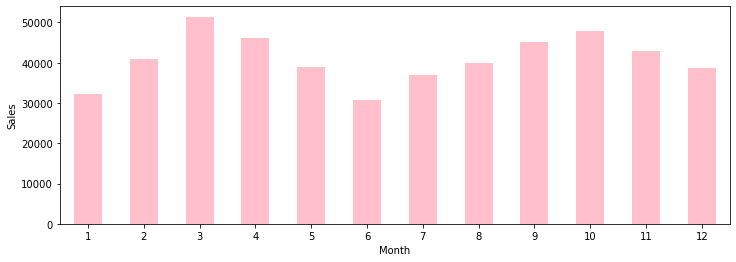

In [1216]:
# Визуализируем продажи по месяцам.
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["Period"].dt.month)["Sales"].sum().plot(kind='bar', rot=0, ax=axs, color='pink')

plt.xlabel("Month");
plt.ylabel("Sales");

Можем сделать вывод, что весной и осенью объемы продаж увеличиваются, что свидетельствует о наличии сезонности.

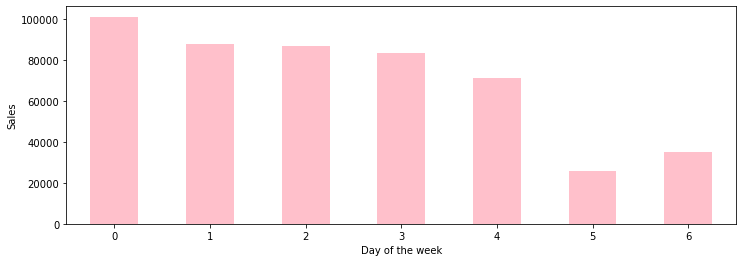

In [1217]:
# И по дням недели.
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["Period"].dt.weekday)["Sales"].sum().plot(kind='bar', rot=0, ax=axs, color='pink')

plt.xlabel("Day of the week");
plt.ylabel("Sales");

В начале недели покупают больше, к концу недели идет спад.

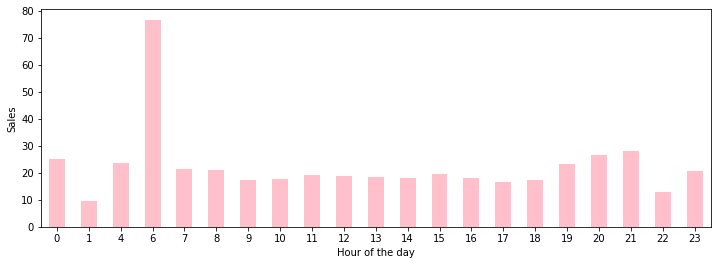

In [1430]:
# Сколько в среднем покупают в разное время суток.
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["Period"].dt.hour)["Sales"].mean().plot(kind='bar', rot=0, ax=axs, color='pink')

plt.xlabel("Hour of the day");
plt.ylabel("Sales");

In [1219]:
df[df["Period"].dt.hour == 6]

,Product,Client,Order,Qty,Sales,Period
27986,Product 17,Клієнт 274,86015,6,76.627907,2019-03-08 06:52:25


В 6 утра совершена одна единственная покупка на сумму 76.627907, поэтому этот показатель выбивается из общей картины. Скорее всего те же причины неравномерности графика после 22:00.

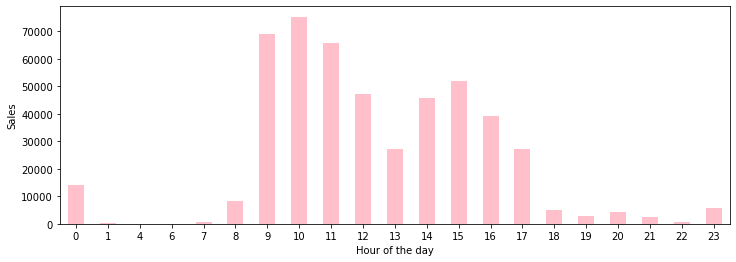

In [1220]:
# И посмотрим на суммы продаж в разное время суток.
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["Period"].dt.hour)["Sales"].sum().plot(kind='bar', rot=0, ax=axs, color='pink')

plt.xlabel("Hour of the day");
plt.ylabel("Sales");

Можем наблюдать 8-часовой рабочий день с 9 до 18 и обеденным перерывом в 13:00.

In [1221]:
df['Sales'].describe()

count    26529.000000
mean        18.541911
std         25.160136
min          0.000000
25%          6.160465
50%         11.690698
75%         21.383721
max        925.302326
Name: Sales, dtype: float64

##### c) ABC-анализ по данным за последний год

In [1222]:
# Выбираем последний год.
df1 = df[df['Period'] > '2019-12-29']
df1['Period'].min(), df1['Period'].max()

(Timestamp('2019-12-31 09:59:59'), Timestamp('2020-12-31 09:40:33'))

In [1223]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13514 entries, 12266 to 26394
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Product  13514 non-null  object        
 1   Client   13514 non-null  object        
 2   Order    13514 non-null  object        
 3   Qty      13514 non-null  int64         
 4   Sales    13514 non-null  float64       
 5   Period   13514 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 739.0+ KB


In [1224]:
# Выбираем нужные столбцы для анализа.
df1 = df1[['Client', 'Sales']]
df1.head(2)

,Client,Sales
12266,Клієнт 22,26.467442
12267,Клієнт 22,24.246512


In [1225]:
# Суммируем продажи по клиентам.
df1 = df1.groupby('Client')['Sales'].sum().reset_index()
df1.head(2)

,Client,Sales
0,Клієнт 1,253.497674
1,Клієнт 10,3038.202326


In [1226]:
# Сортируем
df1.sort_values('Sales', inplace=True, ascending = False)
df1.head(2)

,Client,Sales
695,Клієнт 9,15966.820930
95,Клієнт 20,10470.960465


In [1227]:
# Считаем общую сумму продаж.
general_sales = df1['Sales'].sum()
general_sales

255367.83953488368

In [1228]:
# Считаем накопительные суммы.
df1['Accumulated'] = df1['Sales'].cumsum()
df1.head(2)

,Client,Sales,Accumulated
695,Клієнт 9,15966.820930,15966.820930
95,Клієнт 20,10470.960465,26437.781395


In [1229]:
# Находим соотношение накопительных сумм к общей.
df1['Percent'] = df1['Accumulated']/general_sales*100
df1.head(3)

,Client,Sales,Accumulated,Percent
695,Клієнт 9,15966.820930,15966.820930,6.252479
95,Клієнт 20,10470.960465,26437.781395,10.352823
112,Клієнт 218,7236.995349,33674.776744,13.186773


In [1230]:
# Группируем клиентов.
def group(perc):
    if perc <= 20:
        return 'A'
    elif perc > 20 and perc <= 90:
        return 'B'
    else:
        return 'C'

df1['ABC_category'] = df1['Percent'].map(group)
df1.head()

,Client,Sales,Accumulated,Percent,ABC_category
695,Клієнт 9,15966.820930,15966.820930,6.252479,A
95,Клієнт 20,10470.960465,26437.781395,10.352823,A
112,Клієнт 218,7236.995349,33674.776744,13.186773,A
114,Клієнт 22,6557.979070,40232.755814,15.754825,A
67,Клієнт 172,4023.130233,44255.886047,17.330250,A


In [1231]:
# Посчитаем количество клиентов в разных категориях.
df1['ABC_category'].value_counts()

C    426
B    272
A      6
Name: ABC_category, dtype: int64

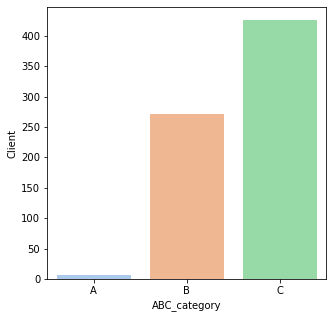

In [1232]:
# Визуализируем количество клиентов по категориям.
df1_ = df1.groupby('ABC_category')['Client'].count().reset_index()
plt.rcParams['figure.figsize']=(5, 5)
sns.barplot(x = 'ABC_category', y = 'Client', data = df1_, palette='pastel')

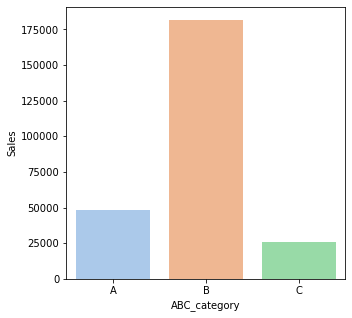

In [1233]:
# Для наглядности визуализируем продажи в каждой группе.
df1__ = df1.groupby('ABC_category')['Sales'].sum().reset_index()
sns.barplot(x = 'ABC_category', y = 'Sales', data = df1__, palette='pastel')

In [1234]:
# Добавим столбец с категорией к основному датафрейму за последний год.
df2 = df[df['Period'] > '2019-12-29'].merge(df1[['Client', 'ABC_category']], how='inner', on='Client')
df2.head()

,Product,Client,Order,Qty,Sales,Period,ABC_category
0,Product 1097,Клієнт 22,3847,1,26.467442,2020-01-21 13:01:25,A
1,Product 1098,Клієнт 22,3847,1,24.246512,2020-01-21 13:01:25,A
2,Product 673,Клієнт 22,3847,1,71.095349,2020-01-21 13:01:25,A
3,Product 699,Клієнт 22,3847,1,53.583721,2020-01-21 13:01:25,A
4,Product 188,Клієнт 22,8719,3,27.437209,2020-01-21 12:52:24,A


In [1235]:
# Сгруппируем покупки клиентов в один момент времени (получим суммы чеков).
df3 = df2.groupby(['Period', 'Client', 'ABC_category'])['Sales'].sum().reset_index()
df3.head(3)

,Period,Client,ABC_category,Sales
0,2019-12-31 09:59:59,Клієнт 36,B,10.862791
1,2020-01-04 08:50:35,Клієнт 95,B,28.839535
2,2020-01-04 09:24:53,Клієнт 22,A,405.967442


In [1236]:
# Посчитаем средний чек по категориям.
df3.groupby('ABC_category')['Sales'].mean()

ABC_category
A    96.978429
B    53.491425
C    27.198055
Name: Sales, dtype: float64

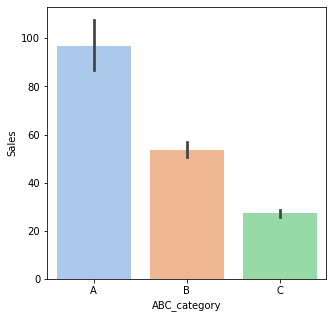

In [1237]:
# Визуализируем средний чек по категориям.
df3.sort_values('ABC_category', inplace=True)
sns.barplot(x = 'ABC_category', y = 'Sales', data = df3, palette='pastel')

###### Вывод:
6 клиентов являются самыми важными, т.к. делают 10% всех продаж со средним чеком 96.98. Для них нужно организвывать специальные предложения, приглашать на мероприятия, дарить подарки.  
Средний чек категории "В" (272 человека) равен 53.50. Это так же важные клиенты, которые делают основную часть продаж. Для них можно устраивать ивенты, спец. предложения и пытаться перетащить их в категорию "А".  
426 клиентов попали в категорию "С" (средний чек = 27,20). Нельзя утверждать, что эти клиенты нам не нужны. Возможно есть разница в продуктах(а не только в количестве), которые покупались группой "А" и "С". Нужно подробнее изучить сами продукты и их цены. Возможно нужно сделать кластеризацию и потом повторить ABC-анализ для клиентов разных кластеров.

##### d) XYZ-анализ (за последний год)  

In [1238]:
# Подготавливаем данные для анализа.
df4 = df.copy()
df4 = df4[df4['Period'] > '2020-01-01'] # выбрали данные за последний год
df4.drop(['Client', 'Order', 'Sales'], inplace=True, axis=1) # удалили ненужные столбцы
df4.head(3)

,Product,Qty,Period
12266,Product 1097,1,2020-01-21 13:01:25
12267,Product 1098,1,2020-01-21 13:01:25
12268,Product 673,1,2020-01-21 13:01:25


In [1239]:
# Создадим новый столбец с номером месяца продажи.
df4['month'] = df4["Period"].dt.month 
df4.drop('Period', inplace=True, axis=1)
df4.head(2)

,Product,Qty,month
12266,Product 1097,1,1
12267,Product 1098,1,1


In [1240]:
df4['month'].unique() # нет продаж в июле месяце, но столбец добавить нужно

array([ 1,  3,  8,  2,  4,  9, 10,  5, 11, 12,  6,  7], dtype=int64)

In [524]:
# Считаем количество продаж товаров по месяцам.
df5 = df4.groupby(['month', 'Product'])['Qty'].sum().reset_index()
df5.head()

,month,Product,Qty
0,1,Product 10,4
1,1,Product 101,45
2,1,Product 104,4
3,1,Product 1097,4
4,1,Product 1098,3


In [525]:
# Создаем сводную таблицу продаж по всем товарам за 12 месяцев.
df5 = df5.pivot(index='Product', columns='month', values='Qty')

# NaN заменяем на 0.
df5.fillna(0, inplace=True)
df5

month,1,2,3,4,5,6,7,8,9,10,11,12
Product,,,,,,,,,,,,
Product 1,0.0,1.0,3.0,0.0,6.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0
Product 10,4.0,2.0,1.0,4.0,2.0,2.0,2.0,6.0,2.0,6.0,5.0,1.0
Product 10031,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
Product 101,45.0,35.0,94.0,53.0,28.0,32.0,44.0,33.0,48.0,36.0,44.0,11.0
Product 104,4.0,12.0,7.0,34.0,12.0,6.0,18.0,3.0,15.0,16.0,16.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Product 9,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Product 944,0.0,0.0,3.0,4.0,1.0,0.0,2.0,1.0,0.0,1.0,2.0,3.0
Product 954,0.0,0.0,0.0,0.0,1.0,3.0,5.0,0.0,1.0,1.0,1.0,0.0


In [526]:
# Посчитаем коэффициент вариации для Продукта 1.
std_ = df5.loc['Product 1'].std(ddof=0)
mean_ = df5.loc['Product 1'].mean()
coef_var = std_/mean_
coef_var

0.9591663046625437

In [527]:
# Напишем функцию для вычисления коэффициента вариации для всех продуктов в датафрейме.
def coef_var(name):
    std_ = df5.loc[name].std(ddof=0)
    mean_ = df5.loc[name].mean()
    coef_var = std_ / mean_
    return coef_var
df5['coef_var'] = df5.index.map(coef_var)

In [528]:
df5

month,1,2,3,4,5,6,7,8,9,10,11,12,coef_var
Product,,,,,,,,,,,,,
Product 1,0.0,1.0,3.0,0.0,6.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,0.959166
Product 10,4.0,2.0,1.0,4.0,2.0,2.0,2.0,6.0,2.0,6.0,5.0,1.0,0.568853
Product 10031,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.118034
Product 101,45.0,35.0,94.0,53.0,28.0,32.0,44.0,33.0,48.0,36.0,44.0,11.0,0.451651
Product 104,4.0,12.0,7.0,34.0,12.0,6.0,18.0,3.0,15.0,16.0,16.0,38.0,0.697687
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Product 9,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.236068
Product 944,0.0,0.0,3.0,4.0,1.0,0.0,2.0,1.0,0.0,1.0,2.0,3.0,0.931940
Product 954,0.0,0.0,0.0,0.0,1.0,3.0,5.0,0.0,1.0,1.0,1.0,0.0,1.471960


In [529]:
xyz = df5.drop([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], axis=1)
xyz.reset_index(inplace=True)

In [536]:
xyz.sort_values('coef_var')

month,Product,coef_var
178,Product 3,0.248323
116,Product 2,0.255063
211,Product 4,0.277822
218,Product 43,0.288517
244,Product 5,0.318949
...,...,...
86,Product 1676,3.316625
135,Product 21400,3.316625
275,Product 6877,3.316625
34,Product 1318,3.316625


In [537]:
# Группируем товары.
def group2(coef):
    if coef <= 0.3:
        return 'X'
    elif coef > 0.3 and coef <= 0.5:
        return 'Y'
    else:
        return 'Z'

df5['XYZ'] = df5['coef_var'].map(group2)

In [538]:
df5['XYZ'].value_counts()

Z    275
Y     28
X      4
Name: XYZ, dtype: int64

In [539]:
df5[df5['XYZ'] == 'X']

month,1,2,3,4,5,6,7,8,9,10,11,12,coef_var,XYZ
Product,,,,,,,,,,,,,,
Product 2,32.0,70.0,68.0,78.0,56.0,50.0,46.0,50.0,64.0,76.0,57.0,34.0,0.255063,X
Product 3,66.0,135.0,139.0,182.0,99.0,115.0,119.0,105.0,149.0,146.0,125.0,82.0,0.248323,X
Product 4,32.0,73.0,71.0,89.0,53.0,56.0,50.0,53.0,65.0,86.0,58.0,37.0,0.277822,X
Product 43,16.0,28.0,46.0,64.0,41.0,41.0,46.0,39.0,52.0,31.0,37.0,40.0,0.288517,X


Text(0.5, 1.0, 'Products in each category')

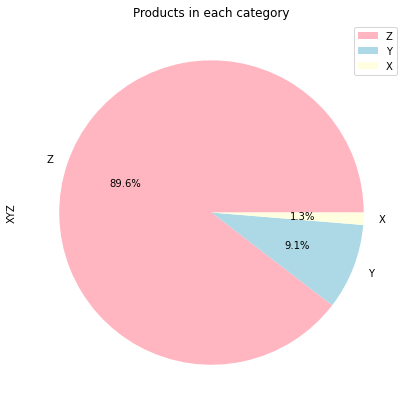

In [596]:
# Визуализируем.
df5_ = df5['XYZ'].value_counts()
df5_.plot(kind='pie', autopct='%1.1f%%', colors=['lightpink', 'lightblue', 'lightyellow'], figsize=(8, 7), legend=True)
plt.title('Products in each category')

##### Выводы
Значения, определяющие "X", "Y" и "Z" для всех рынков свои. Выше мы предполагали некую сезонность, соответственно, мы не можем ограничивать группу "Х" 10%, т.к. у нас таких товаров попросту нет.  
Т.о. 4 товара (Product 2, Product 3, Product 4 и Product 43) характеризуются более-менее стабильной величиной потребления, незначительными колебаниями в их расходе и высокой точностью прогноза(займемся этим вопросом дальше).  
Товары группы "Y" характеризуются известными тенденциями определения потребности в них (например, сезонными колебаниями) и средними возможностями их прогнозирования.  
Потребление товаров из "Z" нерегулярно, какие-либо тенденции отсутствуют, точность прогнозирования невысокая.

### Прогноз продаж (для 4 товаров: 2, 3, 4, 43)

In [763]:
df6 = df.copy()

In [764]:
# Выберем в новый датафрейм только те товары, по которым будем строить прогноз.
df6 = df6[(df6['Product'] == 'Product 2') | (df6['Product'] == 'Product 3') |
          (df6['Product'] == 'Product 4') | (df6['Product'] == 'Product 43')]
df6.head(2)

,Product,Client,Order,Qty,Sales,Period
1,Product 2,Клієнт 2,78554,1,6.093023,2019-02-07 09:42:14
2,Product 3,Клієнт 2,78554,1,3.193023,2019-02-07 09:42:14


In [765]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4276 entries, 1 to 27971
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Product  4276 non-null   object        
 1   Client   4276 non-null   object        
 2   Order    4276 non-null   object        
 3   Qty      4276 non-null   int64         
 4   Sales    4276 non-null   float64       
 5   Period   4276 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 233.8+ KB


In [769]:
df6['Period'].min(), df6['Period'].max(), df6['Period'].max()-df6['Period'].min()

(Timestamp('2018-01-11 09:34:12'),
 Timestamp('2020-12-30 16:14:17'),
 Timedelta('1084 days 06:40:05'))

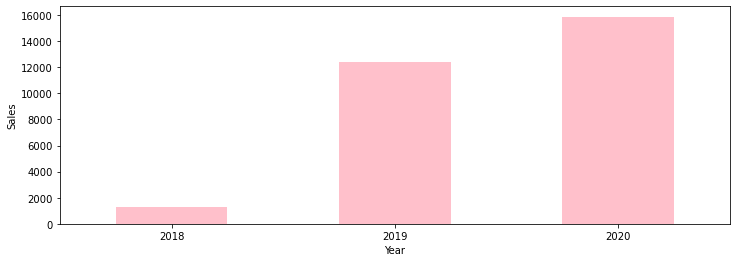

In [767]:
# Посмотрим на суммы продаж по годам.
fig, axs = plt.subplots(figsize=(12, 4))
df6.groupby(df6["Period"].dt.year)["Sales"].sum().plot(kind='bar', rot=0, ax=axs, color='pink')

plt.xlabel("Year");
plt.ylabel("Sales");

Можем наблюдать восходящий тренд. 

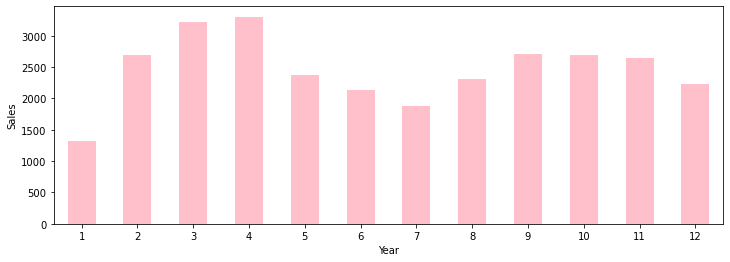

In [768]:
# Посмотрим на средние продажи по месяцам.
fig, axs = plt.subplots(figsize=(12, 4))
df6.groupby(df6["Period"].dt.month)["Sales"].sum().plot(kind='bar', rot=0, ax=axs, color='pink')

plt.xlabel("Year");
plt.ylabel("Sales");

По прежнему видим, что весной и осенью объемы продаж увеличиваются, что свидетельствует о наличии сезонности.

In [770]:
# Обрежем время и дни в датах.
df6['Period'] = pd.to_datetime(df6['Period']).dt.strftime('%Y-%m')
df6['Period'] = pd.to_datetime(df6['Period'])

# Удалим ненужные столбцы.
df6.drop(['Client', 'Order', 'Qty'], axis=1, inplace=True)
df6.head(2)

,Product,Sales,Period
1,Product 2,6.093023,2019-02-01
2,Product 3,3.193023,2019-02-01


In [771]:
# Сделаем сводную таблицу по всем продуктам и индексами-датами.
df6_ = df6.pivot_table(index="Period", columns="Product", values="Sales", aggfunc=np.sum)
df6_.head()

Product,Product 2,Product 3,Product 4,Product 43
Period,,,,
2018-01-01,NaN,5.897674,5.811628,4.630233
2018-02-01,12.234884,12.888372,12.558140,10.288372
2018-03-01,NaN,6.225581,12.269767,NaN
2018-04-01,NaN,6.555814,NaN,NaN
2018-05-01,22.834884,36.158140,23.506977,14.916279


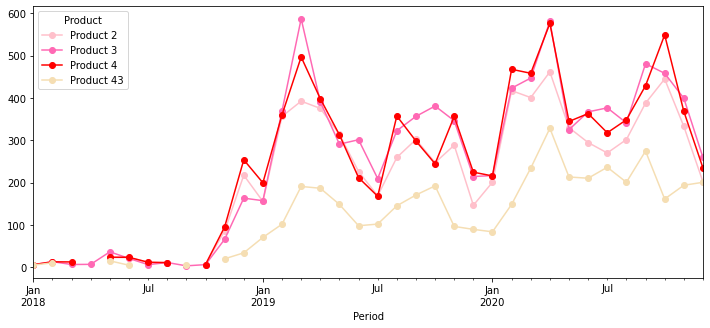

In [772]:
# Построим графики объёма продаж каждого продукта.
df6_.plot(color=('pink', 'hotpink', 'red', 'wheat'), style="-o", figsize=(12, 5), legend=True)

Продолжаем улавливать сезонность и для каждого товара в отдельности.

In [745]:
# Рассмотрим внимательнее наши товары и то, как между ними распределются продажи.
df6.groupby('Product')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Product,,,,,,,,
Product 2,840.0,9.119662,8.610920,2.906977,5.952907,6.332558,7.025581,120.411628
Product 3,1899.0,4.708757,4.372737,2.123256,3.183721,3.362791,3.558140,73.367442
Product 4,878.0,9.968287,9.119894,3.232558,6.330814,6.695349,11.013953,123.153488
Product 43,659.0,6.320037,3.432119,3.400000,4.988372,5.297674,5.519767,30.441860


In [967]:
# На этом месте у меня случился срыв, ибо пришлось все переделывать.

In [1141]:
# Yдалим название индексов и колонок после ресета.
df7 = df6_.rename_axis(None)
df7.columns.name = None
df7.reset_index(inplace=True)
df7.fillna(0.0, inplace=True)

In [1142]:
# Продлим наш датафрейм на прогнозируемый период.
df8 = df7.copy()
df8 = df8.iloc[-12:, :]
df8.loc[:, ['Product 2', 'Product 3', 'Product 4', 'Product 43']] = np.nan

def repl(string):
    new_date = string.replace('2020','2021')
    return new_date

df8['index'] = df8['index'].dt.strftime('%Y-%m-%d').map(repl)
df8['index'] = pd.to_datetime(df8['index'])

In [1143]:
df7 = df7.append(df8)
df7.reset_index(inplace=True)
df7.drop('level_0', axis=1, inplace=True)

In [1144]:
# Создадим регрессионную переменную month_num - порядковый номер пары (месяц, год).
df9 = df7.copy()
df9['month_num'] = range(1, len(df7) + 1)

In [1145]:
# Для начала сделаем столбец с месяцем и столбец с годом.
df9['Year'] = df9["index"].dt.year
df9['Month'] = df9["index"].dt.month
df9.drop('index', axis=1, inplace=True) # удаляем старый столбец с датами
df9.head(2)

,Product 2,Product 3,Product 4,Product 43,month_num,Year,Month
0,0.000000,5.897674,5.811628,4.630233,1,2018,1
1,12.234884,12.888372,12.558140,10.288372,2,2018,2


In [1146]:
# Теперь разбиваем на 12 месяцев(11 колонок) и 3 года(2 колонки).
year = pd.get_dummies(df9['Year'], drop_first=True).copy()
month = pd.get_dummies(df9['Month'], drop_first=True).copy()

In [1147]:
# Удаляем столбцы Year и Month.
df9.drop(['Year', 'Month'], inplace=True, axis=1)

In [1148]:
# Объединяем с нашим датафреймом.
df9 = pd.concat([df9, year, month], axis=1)
df9.head(2)

,Product 2,Product 3,Product 4,Product 43,month_num,2019,2020,2021,2,3,4,5,6,7,8,9,10,11,12
0,0.000000,5.897674,5.811628,4.630233,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12.234884,12.888372,12.558140,10.288372,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [1149]:
# Создадим объекты матрицу X и векторы yi для обучения моделей.
X = df9.iloc[:, 4:]
y_p2  = df9['Product 2']
y_p3 = df9['Product 3']
y_p4 = df9['Product 4']
y_p43 = df9['Product 43']

# Оставим только те строчки, у которых известны значения y(с номером < 36)
X1 = X[X.index < 36]
y1_p2 = y_p2[y_p2.index < 36]
y1_p3 = y_p3[y_p3.index < 36]
y1_p4 = y_p4[y_p4.index < 36]
y1_p43 = y_p43[y_p43.index < 36]

In [1150]:
# Настраиваем линейные регрессионные модели.
from sklearn import set_config
set_config(print_changed_only=False)

from sklearn.linear_model import LinearRegression
lr2 = LinearRegression()
lr3 = LinearRegression()
lr4 = LinearRegression()
lr43 = LinearRegression()

lr2.fit(X1, y1_p2)
lr3.fit(X1, y1_p3)
lr4.fit(X1, y1_p4)
lr43.fit(X1, y1_p43)

pred1_lr2 = lr2.predict(X1)
pred1_lr3 = lr3.predict(X1)
pred1_lr4 = lr4.predict(X1)
pred1_lr43 = lr43.predict(X1)

print(lr2.score(X1, y1_p2))
print(lr3.score(X1, y1_p3))
print(lr4.score(X1, y1_p4))
print(lr43.score(X1, y1_p43))

0.8423807168129225
0.8718810226888851
0.8240334739452313
0.8885288897561568


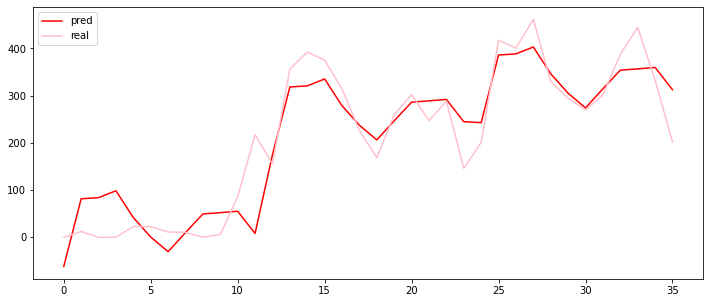

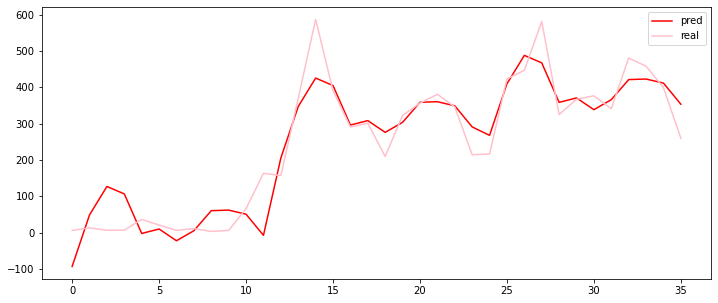

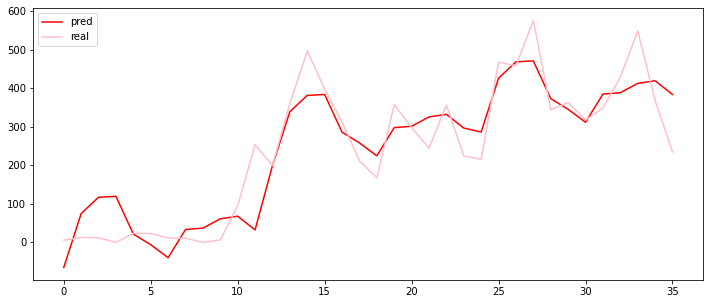

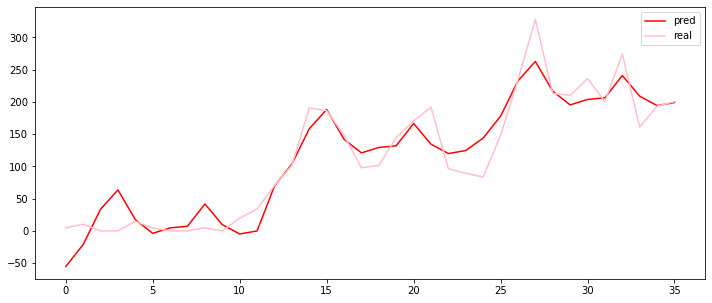

In [1151]:
# Визуализируем
pd.DataFrame({'pred': pred1_lr2, 'real': y1_p2}).plot(color=('red', 'pink'), figsize=(12, 5))
pd.DataFrame({'pred': pred1_lr3, 'real': y1_p3}).plot(color=('red', 'pink'), figsize=(12, 5))
pd.DataFrame({'pred': pred1_lr4, 'real': y1_p4}).plot(color=('red', 'pink'), figsize=(12, 5))
pd.DataFrame({'pred': pred1_lr43, 'real': y1_p43}).plot(color=('red', 'pink'), figsize=(12, 5))

In [1176]:
# Попробуем RandomForestRegressor.
from sklearn.ensemble import RandomForestRegressor
rfr2 = RandomForestRegressor()
rfr3 = RandomForestRegressor()
rfr4 = RandomForestRegressor()
rfr43 = RandomForestRegressor()

rfr2.fit(X1, y1_p2)
rfr3.fit(X1, y1_p3)
rfr4.fit(X1, y1_p4)
rfr43.fit(X1, y1_p43)

pred1_rfr2 = rfr2.predict(X1)
pred1_rfr3 = rfr3.predict(X1)
pred1_rfr4 = rfr4.predict(X1)
pred1_rfr43 = rfr43.predict(X1)

print(rfr2.score(X1, y1_p2))
print(rfr3.score(X1, y1_p3))
print(rfr4.score(X1, y1_p4))
print(rfr43.score(X1, y1_p43))

0.9700295945365337
0.9701653174244261
0.964644402962993
0.9770705569162872


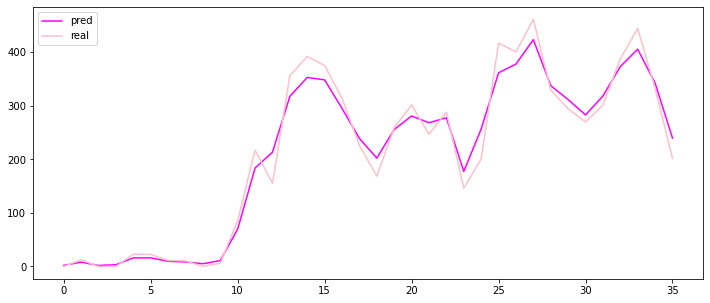

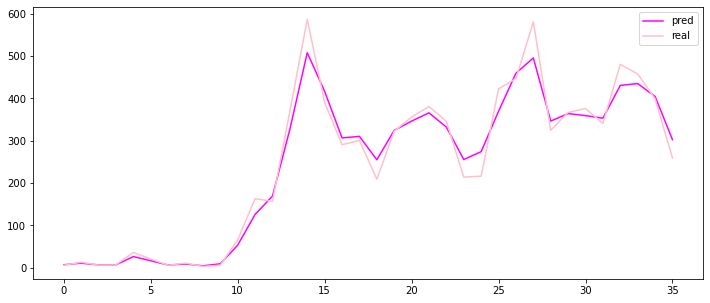

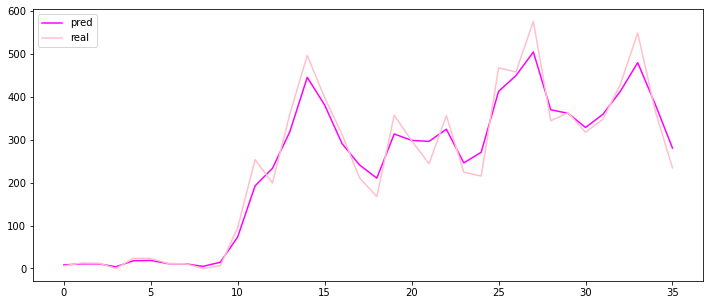

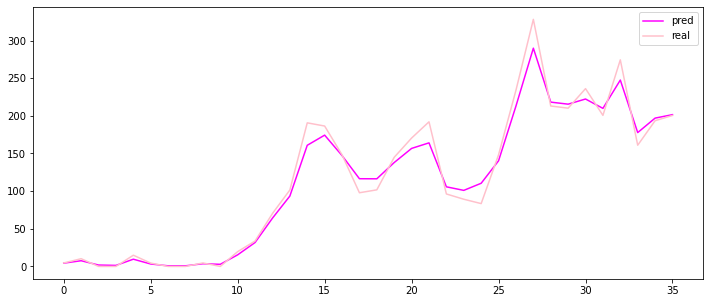

In [1177]:
# Визуализируем RandomForestRegressor.
pd.DataFrame({'pred': pred1_rfr2, 'real': y1_p2}).plot(color=('magenta', 'pink'), figsize=(12, 5))
pd.DataFrame({'pred': pred1_rfr3, 'real': y1_p3}).plot(color=('magenta', 'pink'), figsize=(12, 5))
pd.DataFrame({'pred': pred1_rfr4, 'real': y1_p4}).plot(color=('magenta', 'pink'), figsize=(12, 5))
pd.DataFrame({'pred': pred1_rfr43, 'real': y1_p43}).plot(color=('magenta', 'pink'), figsize=(12, 5))

In [1178]:
# Теперь построим предсказание на будущий год, т.е. для всей матрицы X, включая неизвестные 12 месяцев.
# Линейная регрессия
pred_lr2 = lr2.predict(X)
pred_lr3 = lr3.predict(X)
pred_lr4 = lr4.predict(X)
pred_lr43 = lr43.predict(X)

# Случайный лес
pred_rfr2 = rfr2.predict(X)
pred_rfr3 = rfr3.predict(X)
pred_rfr4 = rfr4.predict(X)
pred_rfr43 = rfr43.predict(X)

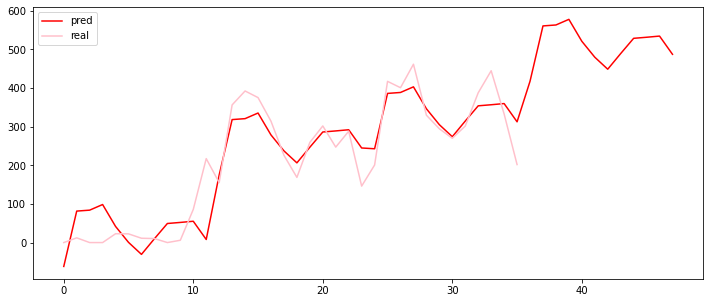

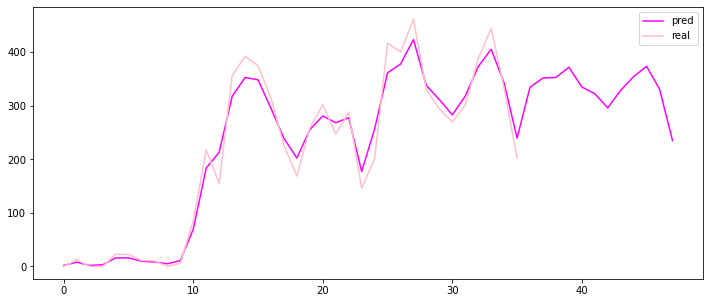

In [1179]:
# Для наглядности строить прогноз будем попарно для каждого продукта.
pd.DataFrame({'pred': pred_lr2, 'real': y_p2}).plot(color=('red', 'pink'), figsize=(12, 5))
pd.DataFrame({'pred': pred_rfr2, 'real': y_p2}).plot(color=('magenta', 'pink'), figsize=(12, 5))

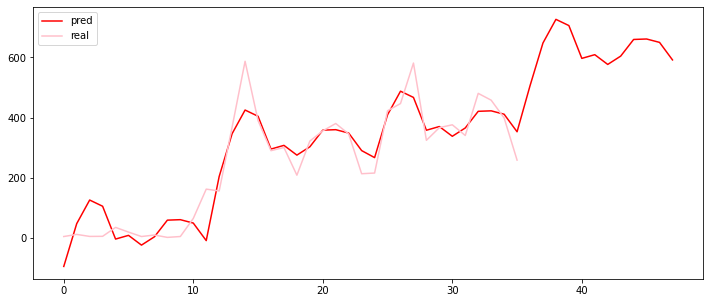

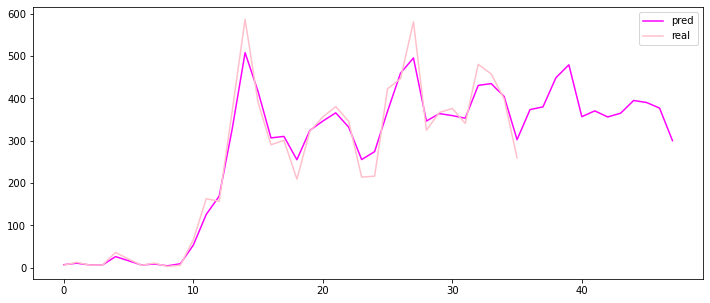

In [1180]:
pd.DataFrame({'pred': pred_lr3, 'real': y_p3}).plot(color=('red', 'pink'), figsize=(12, 5))
pd.DataFrame({'pred': pred_rfr3, 'real': y_p3}).plot(color=('magenta', 'pink'), figsize=(12, 5))

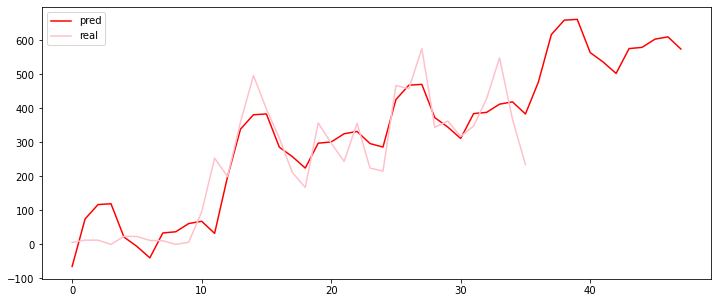

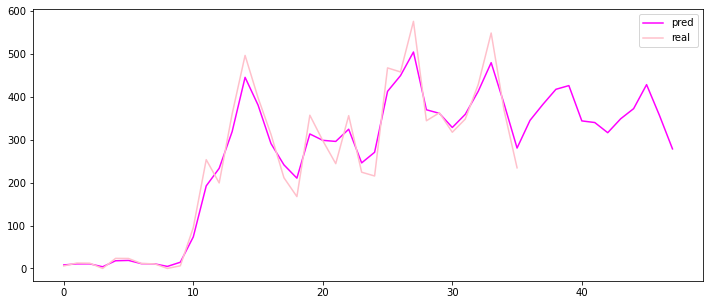

In [1181]:
pd.DataFrame({'pred': pred_lr4, 'real': y_p4}).plot(color=('red', 'pink'), figsize=(12, 5))
pd.DataFrame({'pred': pred_rfr4, 'real': y_p4}).plot(color=('magenta', 'pink'), figsize=(12, 5))

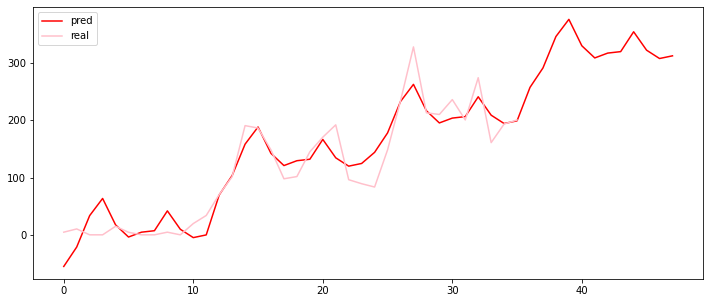

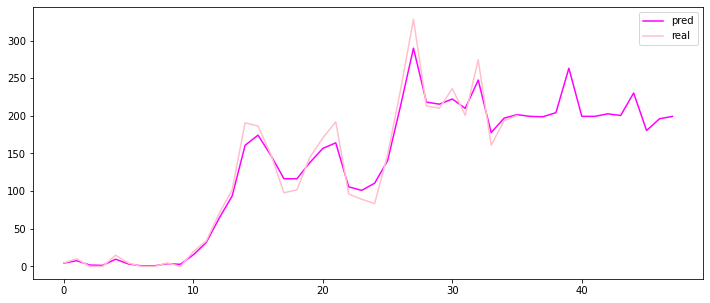

In [1182]:
pd.DataFrame({'pred': pred_lr43, 'real': y_p43}).plot(color=('red', 'pink'), figsize=(12, 5))
pd.DataFrame({'pred': pred_rfr43, 'real': y_p43}).plot(color=('magenta', 'pink'), figsize=(12, 5))

Модель RandomForestRegressor имеет более высокую оценку точности на тренировочных данных, потому будем использовать для прогноза её.

In [1173]:
# Создадим новый датафрейм с прогнозом на 2021 год по 4 продуктам.
df_final = df7[df7.index > 35]
df_final['Product 2'] = pred_rfr2[-12:]
df_final['Product 3'] = pred_rfr3[-12:]
df_final['Product 4'] = pred_rfr4[-12:]
df_final['Product 43'] = pred_rfr43[-12:]

<ipython-input-1173-262e025ade0c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Product 2'] = pred_rfr2[-12:]
<ipython-input-1173-262e025ade0c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Product 3'] = pred_rfr3[-12:]
<ipython-input-1173-262e025ade0c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [1174]:
df_final

,index,Product 2,Product 3,Product 4,Product 43
36,2021-01-01,320.144581,367.192744,330.737791,196.180558
37,2021-02-01,341.427395,373.884140,355.672535,196.180558
38,2021-03-01,347.411953,460.060395,412.411907,199.964721
39,2021-04-01,346.694744,499.348953,401.253581,258.231860
40,2021-05-01,322.055698,354.627209,332.005744,196.505465
41,2021-06-01,304.637628,366.751465,319.658140,196.734233
42,2021-07-01,285.354721,354.393628,308.626791,201.185535
43,2021-08-01,312.976349,362.004023,334.941581,196.060116
44,2021-09-01,331.829442,393.205581,366.430209,221.902791
45,2021-10-01,346.279186,384.913651,421.759372,181.260953


По данному прогнозу можем определиться с количеством закупок данных товаров на 2021 год.

In [1250]:
# Так-то реальные данные за январь у нас есть (возможно не полные), проверим себя.

dff = pd.read_excel('practice.xlsx')
dff['Period'] = pd.to_datetime(dff['Period'])
dff.drop(dff[dff['Qty'] == 0].index, inplace=True, axis=0)

In [1251]:
dff = dff[(dff['Period'] > '2020-01-01') & (dff['Period'] < '2020-02-01')]

In [1252]:
dff['Period'] = pd.to_datetime(dff['Period']).dt.strftime('%Y-%m')
dff['Period'] = pd.to_datetime(dff['Period'])

In [1256]:
dff = dff.groupby(['Product', 'Period'])['Sales'].sum().reset_index()

In [1258]:
real_jan = dff[(dff['Product'] == 'Product 2') | (dff['Product'] == 'Product 3') |
(dff['Product'] == 'Product 4') | (dff['Product'] == 'Product 43')]
real_jan

,Product,Period,Sales
38,Product 2,2020-01-01,200.688372
66,Product 3,2020-01-01,216.395349
88,Product 4,2020-01-01,215.574419
94,Product 43,2020-01-01,83.448837


Видимо данные все таки не полные, т.к. прогноз от реальных данных отличается на 100 по каждому продукту.

### Ассоциативные связи

In [1309]:
from apyori import apriori

In [1434]:
data = pd.read_excel('practice.xlsx')
data['Period'] = pd.to_datetime(data['Period'])
data.drop(data[data['Qty'] == 0].index, inplace=True, axis=0) #  или оставить???

In [1436]:
# Количество товаров.
print(len(data['Product'].unique()))

# Количество клиентов.
print(len(data['Client'].unique()))

# Количество чеков.
print(len(data['Order'].unique()))

355
889
9835


In [1349]:
# Посчитаем количество чеков.
print(data.shape)
len(data['Order'].unique()) 

(27973, 2)


9835

In [1351]:
# Посмотрим, сколько всего есть товаров.
qty = len(data['Product'].unique())
qty

355

In [1407]:
# Сделаем сводную таблицу.
basket = data.groupby(['Order', 'Product'])['Qty'].sum().unstack().fillna(0)
basket.head()

Product,Product 1,Product 10,Product 10031,Product 101,Product 10281,Product 104,Product 10457,Product 1084,Product 1097,Product 1098,...,Product 8328,Product 8494,Product 8640,Product 879,Product 9,Product 910,Product 944,Product 954,Product 9681,Product 9760
Order,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1408]:
# Заменим все значения, отличные от нуля, единичкой.
def replace_units(el):
    if el <= 0:
        return 0
    elif el > 0:
        return 1
    
basket = basket.applymap(replace_units)
basket.head()

Product,Product 1,Product 10,Product 10031,Product 101,Product 10281,Product 104,Product 10457,Product 1084,Product 1097,Product 1098,...,Product 8328,Product 8494,Product 8640,Product 879,Product 9,Product 910,Product 944,Product 954,Product 9681,Product 9760
Order,,,,,,,,,,,,,,,,,,,,,
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1427]:
# Теперь генерируем ассоциативные правила.
association_rules = apriori(basket, min_suport = 0.004,, use_colnames=True)

In [1428]:
# Список с правилами.
association_results = list(association_rules)
association_results

[RelationRecord(items=frozenset({' '}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({' '}), confidence=1.0, lift=1.0)]),
 RelationRecord(items=frozenset({'0'}), support=0.2535211267605634, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'0'}), confidence=0.2535211267605634, lift=1.0)]),
 RelationRecord(items=frozenset({'1'}), support=0.5154929577464789, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'1'}), confidence=0.5154929577464789, lift=1.0)]),
 RelationRecord(items=frozenset({'2'}), support=0.37464788732394366, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'2'}), confidence=0.37464788732394366, lift=1.0)]),
 RelationRecord(items=frozenset({'3'}), support=0.36338028169014086, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'3'}), confidence=0.36338028169014086, lift=1.0)]),
 RelationRecord(items

Максимальный лифт, который образовывает связи = 1.11, слишком мал. Значит сильных зависимостей нет. Минимальный = 0.8751386663379761, что также не свидетельствует о сильной обратной зависимости группы продуктов.

## Выводы:
* были исследованы данные о 9835 продажах 355 товаров 877 клиентам;
* выявлена сезонность: весна-осень больше продаж;
* по загруженности: 5-дневный 8-часовой рабочий день с 9 до 18 и обеденным перерывом в 13:00;
* результаты ABC-анализа:  
  * 6 клиентов являются самыми важными, т.к. делают 10% всех продаж со средним чеком 96.98. Для них нужно организвывать специальные предложения, приглашать на мероприятия, дарить подарки.
  * Средний чек категории "В" (272 человека) равен 53.50. Это так же важные клиенты, которые делают основную часть продаж. Для них можно устраивать ивенты, спец. предложения и пытаться перетащить их в категорию "А".
  * 426 клиентов попали в категорию "С" (средний чек = 27,20). Нельзя утверждать, что эти клиенты нам не нужны. Возможно есть разница в продуктах(а не только в количестве), которые покупались группой "А" и "С". Нужно подробнее изучить сами продукты и их цены. Возможно можно сделать кластеризацию и потом повторить ABC-анализ для клиентов разных кластеров.
* результаты XYZ-анализа (за последний год):
  * Четыре товара (Product 2, Product 3, Product 4 и Product 43) характеризуются более-менее стабильной величиной потребления, незначительными колебаниями в их расходе и высокой точностью прогноза;
* построен прогноз продаж (для 4 товаров: №2, №3, №4, №43) с помощью линейной регрессионной модели и случайного леса.
  * высокая точность на известных данных (0.9700295945365337, 0.9701653174244261, 0.964644402962993, 0.9770705569162872) у случайного леса, потому выбираем прогноз на год ``df_final``
* кластеры не обнаружены;
* наличиние ассоциативных связей отсутствует (зависимости нет)

In [1437]:
df_final

,index,Product 2,Product 3,Product 4,Product 43
36,2021-01-01,320.144581,367.192744,330.737791,196.180558
37,2021-02-01,341.427395,373.884140,355.672535,196.180558
38,2021-03-01,347.411953,460.060395,412.411907,199.964721
39,2021-04-01,346.694744,499.348953,401.253581,258.231860
40,2021-05-01,322.055698,354.627209,332.005744,196.505465
41,2021-06-01,304.637628,366.751465,319.658140,196.734233
42,2021-07-01,285.354721,354.393628,308.626791,201.185535
43,2021-08-01,312.976349,362.004023,334.941581,196.060116
44,2021-09-01,331.829442,393.205581,366.430209,221.902791
45,2021-10-01,346.279186,384.913651,421.759372,181.260953
